### Load required libraries

In [1]:
import numpy as np
from scipy.integrate import odeint
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline 
import seaborn as sns


### Chikungunya model

In [2]:
def chikungunya_model(y, t, params):
    
    # Unpack parameters
    (
        b, beta_mh, beta_hm,
        contact_rate_1, contact_rate_2,
        vaccination_rate_1, vaccination_rate_2,
        severe_prob_1, severe_prob_2,
        chronic_prob_m, chronic_prob_s,
        gamma_m, gamma_s, gamma_c,
        sigma, sigma_m,
        mu, mu_m, Lambda_m,
        prop_age1_Im, prop_age1_Is, prop_age1_C, prop_age1_R, prop_age1_V
    ) = params
    
    # State variables
    S1, E1, S2, E2, Im, Is, C, R, V, Sm, Em, Im_mosq = y
    
    # Age-specific population sizes
    N1 = (S1 + E1 + prop_age1_Im*Im + prop_age1_Is*Is +
          prop_age1_C*C + prop_age1_R*R + prop_age1_V*V)
    
    N2 = (S2 + E2 + (1-prop_age1_Im)*Im + (1-prop_age1_Is)*Is +
          (1-prop_age1_C)*C + (1-prop_age1_R)*R + (1-prop_age1_V)*V)
    
    N_total = N1 + N2
    I_total = Im + Is

    # Forces of infection
    lambda_h = b * beta_mh * Im_mosq / N_total
    lambda_m = b * beta_hm * I_total / N_total
    
    lambda_h1 = lambda_h * contact_rate_1
    lambda_h2 = lambda_h * contact_rate_2
    
    # ODEs
    dS1 = mu*N1 - mu*S1 - lambda_h1*S1 - vaccination_rate_1*S1
    dE1 = lambda_h1*S1 - (sigma + mu)*E1
    
    dS2 = mu*N2 - mu*S2 - lambda_h2*S2 - vaccination_rate_2*S2
    dE2 = lambda_h2*S2 - (sigma + mu)*E2
    
    dIm = (
        sigma*(1-severe_prob_1)*E1 +
        sigma*(1-severe_prob_2)*E2 -
        (gamma_m + mu + chronic_prob_m*gamma_m)*Im
    )
    
    dIs = (
        sigma*severe_prob_1*E1 +
        sigma*severe_prob_2*E2 -
        (gamma_s + mu + chronic_prob_s*gamma_s)*Is
    )
    
    dC = (
        chronic_prob_m*gamma_m*Im +
        chronic_prob_s*gamma_s*Is -
        (gamma_c + mu)*C
    )
    
    dR = (
        (1-chronic_prob_m)*gamma_m*Im +
        (1-chronic_prob_s)*gamma_s*Is +
        gamma_c*C - mu*R
    )
    
    dV = vaccination_rate_1*S1 + vaccination_rate_2*S2 - mu*V
    
    # Mosquito equations
    dSm = Lambda_m - mu_m*Sm - lambda_m*Sm
    dEm = lambda_m*Sm - (sigma_m + mu_m)*Em
    dIm_mosq = sigma_m*Em - mu_m*Im_mosq
    
    return [
        dS1, dE1, dS2, dE2, dIm, dIs, dC, dR, dV,
        dSm, dEm, dIm_mosq
    ]


### Simulation Runner

In [3]:
def run_chikungunya_simulation(params, initial_conditions, time_points):
    
    # Solve ODE system
    sol = odeint(
        func=lambda y, t: chikungunya_model(y, t, params),
        y0=initial_conditions,
        t=time_points
    )
    
    # Convert to dataframe
    columns = [
        "S1", "E1", "S2", "E2", "Im", "Is", "C", "R", "V",
        "Sm", "Em", "Im_mosq"
    ]
    
    df = pd.DataFrame(sol, columns=columns)
    df["time"] = time_points
    
    return df


## PLOTTING FUNCTIONS
### Age-specific susceptible + Exposed

In [4]:
def plot_age_specific(df):
    plt.figure(figsize=(10,6))
    sns.lineplot(df, x="time", y="S1", label="S1 (<60)")
    sns.lineplot(df, x="time", y="E1", label="E1 (<60)")
    sns.lineplot(df, x="time", y="S2", label="S2 (60+)")
    sns.lineplot(df, x="time", y="E2", label="E2 (60+)")
    
    plt.title("Age-Specific Susceptible and Exposed")
    plt.xlabel("Time (days)")
    plt.ylabel("Population")
    plt.legend()
    plt.tight_layout()
    plt.show()


### Disease states(Im,Is,C,R,V)

In [5]:
def plot_disease_states(df):
    plt.figure(figsize=(10,6))
    for col in ["Im", "Is", "C", "R", "V"]:
        sns.lineplot(df, x="time", y=col, label=col)
        
    plt.title("Disease States (Age-independent)")
    plt.xlabel("Time (days)")
    plt.ylabel("Population")
    plt.legend()
    plt.tight_layout()
    plt.show()


### Mosquito compartments

In [6]:
def plot_mosquito(df):
    plt.figure(figsize=(10,6))
    for col in ["Sm", "Em", "Im_mosq"]:
        sns.lineplot(df, x="time", y=col, label=col)
        
    plt.title("Mosquito Compartments")
    plt.xlabel("Time (days)")
    plt.ylabel("Mosquito Population")
    plt.legend()
    plt.tight_layout()
    plt.show()


### Key Indicators

In [7]:
def plot_indicators(df):
    df["Total_Infectious"] = df["Im"] + df["Is"]
    df["Total_Susceptible"] = df["S1"] + df["S2"]
    df["Total_Exposed"] = df["E1"] + df["E2"]
    
    plt.figure(figsize=(10,6))
    for col in ["Total_Infectious", "C", "Total_Susceptible"]:
        sns.lineplot(df, x="time", y=col, label=col)
        
    plt.title("Key Epidemiological Indicators")
    plt.xlabel("Time (days)")
    plt.ylabel("Population")
    plt.legend()
    plt.tight_layout()
    plt.show()


In [9]:
def plot_chikungunya_results(df):
    plot_age_specific(df)
    plot_disease_states(df)
    plot_mosquito(df)
    plot_indicators(df)


In [10]:
plot_age_specific(df)

NameError: name 'df' is not defined

R0 = 0.312


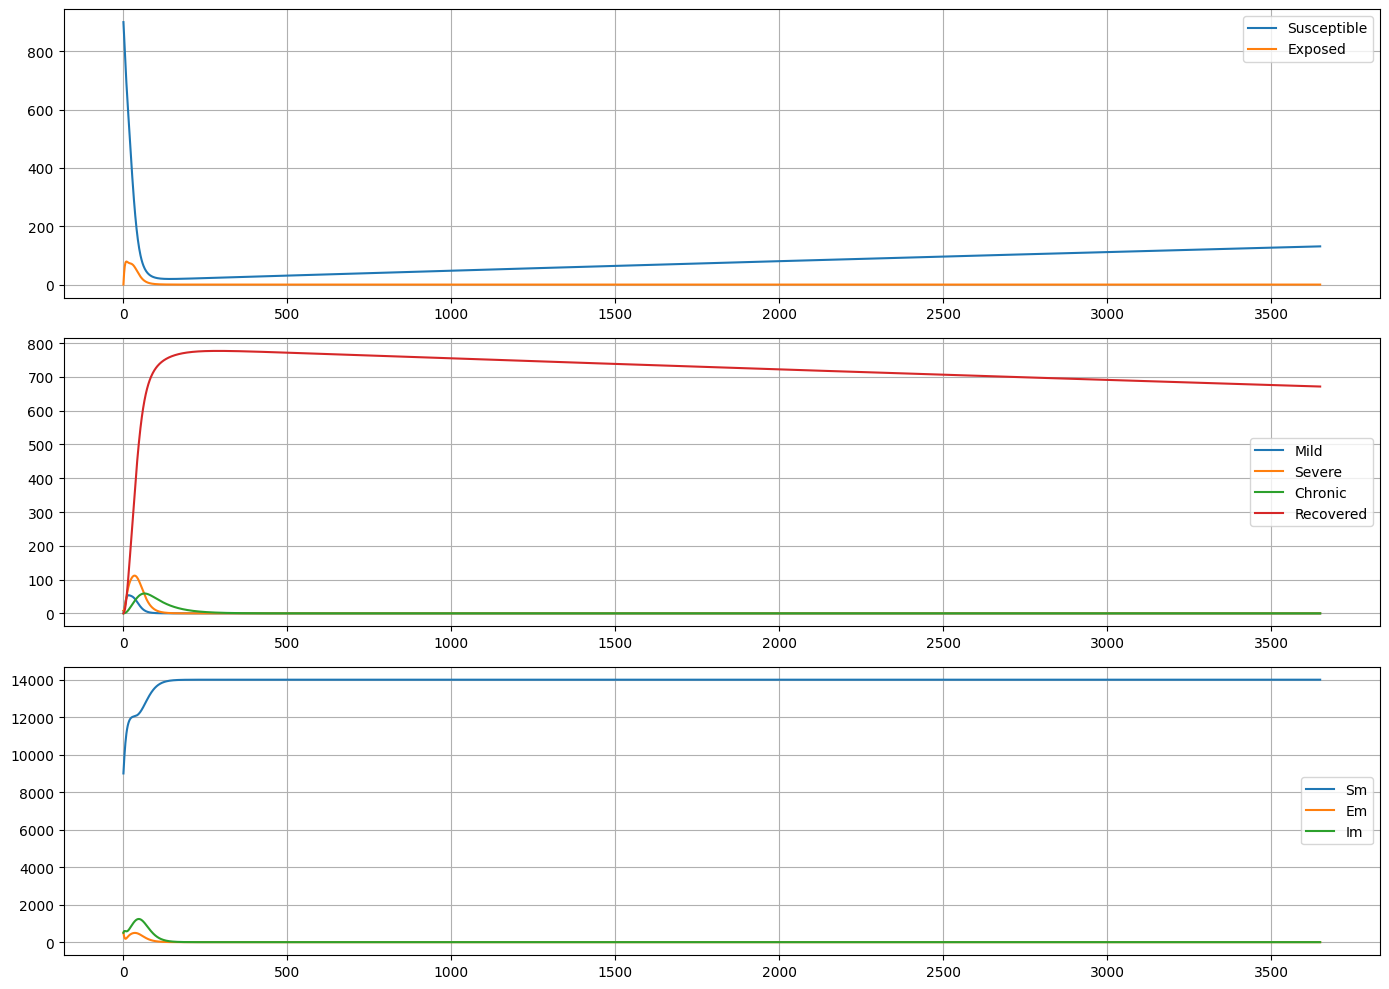

In [ ]:
# -*- coding: utf-8 -*-
"""
CHIKUNGUNYA MODEL – KENYA (NO VACCINATION)
-----------------------------------------
Flow:
S → E → Im → {Is, R}
Is → {C, R}
C → R
"""

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.integrate import odeint

# -----------------------------------------------------------------------------
# CORE MODEL
# -----------------------------------------------------------------------------
def chikungunya_model(y, t, p):

    (
        mu, sigma,
        gamma_m, gamma_s, gamma_c,
        severe_prob_1, severe_prob_2,
        chronic_prob_s, mu_ms,
        c1, c2,
        prop1_Im, prop1_Is, prop1_C, prop1_R,
        Lambda_m, mu_m, sigma_m,
        b, beta_hm, beta_mh
    ) = p.values()

    # State variables (11)
    S1, E1, S2, E2, Im, Is, C, R, Sm, Em, Im_m = y

    # Human population
    N1 = S1 + E1 + prop1_Im*Im + prop1_Is*Is + prop1_C*C + prop1_R*R
    N2 = S2 + E2 + (1-prop1_Im)*Im + (1-prop1_Is)*Is + (1-prop1_C)*C + (1-prop1_R)*R
    Nh = N1 + N2

    Ih = Im + Is  

    # Forces of infection
    lambda_h = b * beta_mh * Im_m / Nh #Force of infection on humans
    lambda_m = b * beta_hm * Ih / Nh #Force of infection on mosquitoes

    lambda_h1 = c1 * lambda_h
    lambda_h2 = c2 * lambda_h

    # Human equations
    dS1 = mu*N1 - mu*S1 - lambda_h1*S1
    dE1 = lambda_h1*S1 - (sigma + mu)*E1

    dS2 = mu*N2 - mu*S2 - lambda_h2*S2
    dE2 = lambda_h2*S2 - (sigma + mu)*E2

    dIm = sigma*(1-severe_prob_1)*E1 + sigma*(1-severe_prob_2)*E2 \
          - (gamma_m + mu + mu_ms)*Im

    dIs = sigma*severe_prob_1*E1 + sigma*severe_prob_2*E2 \
          + mu_ms*Im - (gamma_s + chronic_prob_s*gamma_s + mu)*Is

    dC = chronic_prob_s*gamma_s*Is - (gamma_c + mu)*C

    dR = gamma_m*Im + (1-chronic_prob_s)*gamma_s*Is + gamma_c*C - mu*R

    # Mosquito equations
    dSm = Lambda_m - mu_m*Sm - lambda_m*Sm
    dEm = lambda_m*Sm - (sigma_m + mu_m)*Em
    dIm_m = sigma_m*Em - mu_m*Im_m

    return [dS1, dE1, dS2, dE2, dIm, dIs, dC, dR, dSm, dEm, dIm_m]

# -----------------------------------------------------------------------------
# SIMULATION
# -----------------------------------------------------------------------------
def run_simulation(params, y0, t):

    sol = odeint(chikungunya_model, y0, t, args=(params,))
    cols = ["S1","E1","S2","E2","Im","Is","C","R","Sm","Em","Im_m"]
    df = pd.DataFrame(sol, columns=cols)
    df["time"] = t

    # Incidence
    inc = []
    for _, r in df.iterrows():
        Nh = r.S1 + r.E1 + r.S2 + r.E2 + r.Im + r.Is + r.C + r.R
        lambda_h = params["b"] * params["beta_mh"] * r.Im_m / Nh
        inc.append(lambda_h*(params["contact_rate_1"]*r.S1 +
                              params["contact_rate_2"]*r.S2))

    df["Incidence"] = inc
    return df

# -----------------------------------------------------------------------------
# BASIC R0 (heuristic)
# -----------------------------------------------------------------------------
def R0_estimate(p):

    Dm = 1/(p["gamma_m"] + p["mu"] + p["mu_ms"])
    Ds = 1/(p["gamma_s"] + p["mu"])
    psev = (p["severe_prob_1"] + p["severe_prob_2"]) / 2

    D = (1-psev)*Dm + psev*Ds
    pm = p["sigma_m"]/(p["sigma_m"] + p["mu_m"])

    return (p["b"]**2 * p["beta_hm"] * p["beta_mh"] * pm * D) / p["mu_m"]

# -----------------------------------------------------------------------------
# PLOTTING
# -----------------------------------------------------------------------------
def plot_results(df):

    plt.figure(figsize=(14,10))

    plt.subplot(3,1,1)
    plt.plot(df.time, df.S1+df.S2, label="Susceptible")
    plt.plot(df.time, df.E1+df.E2, label="Exposed")
    plt.legend(); plt.grid()

    plt.subplot(3,1,2)
    plt.plot(df.time, df.Im, label="Mild")
    plt.plot(df.time, df.Is, label="Severe")
    plt.plot(df.time, df.C, label="Chronic")
    plt.plot(df.time, df.R, label="Recovered")
    plt.legend(); plt.grid()

    plt.subplot(3,1,3)
    plt.plot(df.time, df.Sm, label="Sm")
    plt.plot(df.time, df.Em, label="Em")
    plt.plot(df.time, df.Im_m, label="Im")
    plt.legend(); plt.grid()

    plt.tight_layout()
    plt.show()

# -----------------------------------------------------------------------------
# MAIN
# -----------------------------------------------------------------------------
def main():

    params = dict(
        mu = 1/(62*365),
        sigma = 1/4,
        gamma_m = 1/7,
        gamma_s = 1/14,
        gamma_c = 1/60,
        severe_prob_1 = 0.1,
        severe_prob_2 = 0.7,
        chronic_prob_s = 0.25,
        mu_ms = 1/10,
        contact_rate_1 = 1.0,
        contact_rate_2 = 0.5,
        prop1_Im = 0.8,
        prop1_Is = 0.2,
        prop1_C = 0.2,
        prop1_R = 0.8,
        Lambda_m = 1000,
        mu_m = 1/14,
        sigma_m = 1/5,
        b = 0.25,
        beta_hm = 0.25,
        beta_mh = 0.24
    )

    y0 = [
        500, 0,
        400,   0,
        7, 8, 0, 0,
        9000, 500, 500
    ]

    t = np.arange(0, 365*10, 1)

    df = run_simulation(params, y0, t)
    print("R0 =", round(R0_estimate(params), 3))
    plot_results(df)

    return df

if __name__ == "__main__":
    main()
